In [ ]:
# default_exp sampler.direct_sampler

# Direct Monte Carlo sampler

> Sampler class for direct Monte Carlo sampling

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
#export
import qsam.math as math
from qsam.callbacks import CallbackList
from qsam.sampler.base_sampler import BaseSampler

import numpy as np
from tqdm.auto import tqdm # automatically choose jupyter tqdm version when available.

In [ ]:
#export

class DirectSampler(BaseSampler):
        
    def setup(self):
        n_p_phy = len(self.fault_gen.p_phy)
        self.cnts = np.zeros( n_p_phy )
        self.fail_cnts = np.zeros( n_p_phy )
        
    def stats(self, p_idx=..., var_fn=math.Wilson_var):
        rate = self.fail_cnts[p_idx] / self.cnts[p_idx]
        var = var_fn(rate, self.cnts[p_idx])
        return rate, np.sqrt(var)
    
    def loop_fn(self, kwargs):
        circuit_hash = kwargs["circuit_hash"]
        p_phy = kwargs["p_phy"]
        w_vec, faults = self.fault_gen.faults_from_probs(p_phy, circuit_hash)
        w_idx = self.w_vecs[circuit_hash].index(w_vec)
        return {'w_vec': w_vec, 'w_idx': w_idx, 'faults': faults}
    
    def run(self, n_samples, callbacks=[]):
        
        if not isinstance(callbacks, CallbackList):
            callbacks = CallbackList(sampler=self, callbacks=callbacks)       
        callbacks.on_sampler_begin()
        
        for i, p_phy in enumerate(tqdm(self.fault_gen.p_phy, desc='Total')):  
            self.stop_sampling = False
            self.p_idx = i
            
            for _ in tqdm(range(n_samples), desc=f'p_phy={",".join(list(f"{p:.2E}" for p in p_phy))}', leave=True):
                self.cnts[i] += 1
                self.fail_cnts[i] += self.sample(callbacks, p_phy=p_phy)
                if self.stop_sampling: break
        
        callbacks.on_sampler_end()

Let's try it out:

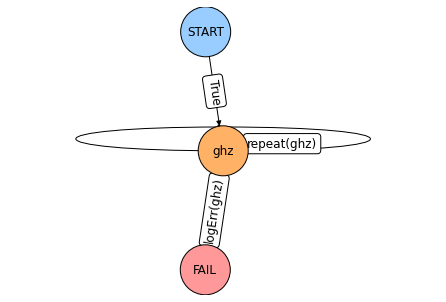

In [ ]:
#slow
from qsam.examples.protocols import ghz3
ghz3.draw()

In [ ]:
#slow

from qsam.simulators.chp import ChpSimulator
from qsam.simulators.projectq import StateVectorSimulator
from qsam.fault_generators import Depolarizing
import qsam.callbacks as cb

sample_range = np.logspace(-3,0,5)
err_params = {'p': sample_range}

fault_gen = Depolarizing(err_params)
sam = DirectSampler(ghz3, ChpSimulator, fault_gen)

# callbacks = [
#     cb.RelStdTarget(target=0.5),
#     cb.PlotStats(),
# ]

sam.run(n_samples=10000, callbacks=[])
sam.tree.draw()

Total:   0%|          | 0/5 [00:00<?, ?it/s]

p_phy=1.00E-03:   0%|          | 0/10000 [00:00<?, ?it/s]

p_phy=5.62E-03:   0%|          | 0/10000 [00:00<?, ?it/s]

p_phy=3.16E-02:   0%|          | 0/10000 [00:00<?, ?it/s]

p_phy=1.78E-01:   0%|          | 0/10000 [00:00<?, ?it/s]

p_phy=1.00E+00:   0%|          | 0/10000 [00:00<?, ?it/s]